# Import, load data

In [22]:
import torch
import torch.nn as nn
from torch.functional import F
from utils.utils0 import *
from utils.utils1 import *
from utils.utils1 import ModelParams, model_loader, print_summary#, test_repeat
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Device: {device}')

mse = nn.MSELoss()

Device: cuda


In [23]:
model_params = ModelParams(dataset=2, sup=1)
test_dataset = datagen(model_params.dataset, False, model_params.sup)


Model name:  dataset2_sup1_image1_points0_loss_image0
Model code:  21100_0.001_0_10_1
Model params:  {'dataset': 2, 'sup': 1, 'image': 1, 'points': 0, 'loss_image_case': 0, 'loss_image': MSELoss(), 'loss_affine': <utils.utils1.loss_affine object at 0x7fc6f43a2ca0>, 'learning_rate': 0.001, 'decay_rate': 0.96, 'start_epoch': 0, 'num_epochs': 10, 'batch_size': 1, 'model_name': 'dataset2_sup1_image1_points0_loss_image0'}


In [24]:
# draw a pair of images from the test set
A, B, affine_param, pt1, pt2, pt3 = list(test_dataset)[0]

In [25]:
A = torch.concat([A, B], dim=0)[0]

In [26]:
pt1.shape, pt2.shape, pt3.shape

(torch.Size([1, 108, 2]), torch.Size([1, 108, 2]), torch.Size([1, 108, 2]))

In [27]:
pt1_T = pt1.transpose(-1, 2).squeeze(0)
pt2_T = pt2.transpose(-1, 2).squeeze(0)
pt3_T = pt3.transpose(-1, 2).squeeze(0)

In [28]:
identity = torch.tensor([[1.0, 0.0, 0.0],
                                [0.0, 1.0, 0.0]])

# How I always do it

In [29]:
def transform_points_DVF(points, M, image):
    # transform points using displacement field
    # DVF.shape = (2, H, W)
    # points.shape = (2, N)
    displacement_field = torch.zeros(image.shape[-1], image.shape[-1])
    DVF = transform_to_displacement_field(
        displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)), 
        M.view(1, 2, 3))

    # Reshape tensor points to have dimensions [2, N]
    points = points.long()

    # Use torch.gather to select values from A using indices from points
    result = DVF[:, points[:, 0], points[:, 1]]

    # Reshape result to have dimensions [2, N]
    result = result.t()
    # subtract the result from the original points
    points = points.float()
    result = torch.subtract(points, result)
    return result

# def transform_points_DVF(points, M, image):
#     # transform points using displacement field
#     # DVF.shape = (2, H, W)
#     # points.shape = (2, N)
#     displacement_field = torch.zeros(image.shape[-1], image.shape[-1])
#     DVF = transform_to_displacement_field(
#         displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)), 
#         M.clone().view(1, 2, 3))
#     if isinstance(DVF, torch.Tensor):
#         DVF = DVF.numpy()
#     # loop through each point and apply the transformation
#     for i in range(points.shape[1]):
#         points[:, i] = points[:, i] - DVF[:, int(points[1, i]), int(points[0, i])]
#     return points

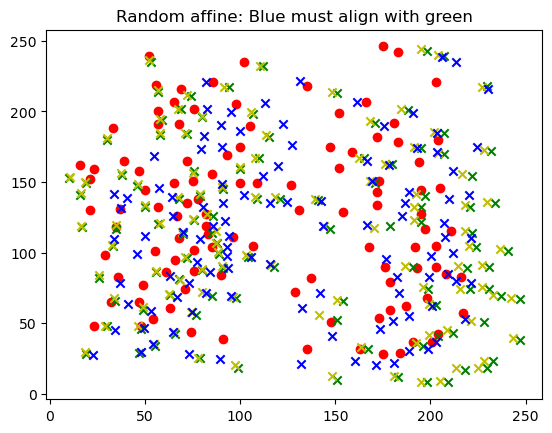

In [30]:
transformed_points = transform_points_DVF(pt1_T, affine_param[0], A)
# show the original points and the transformed points
plt.scatter(pt1_T[:, 0], pt1_T[:, 1], c='r')
plt.scatter(pt2_T[:, 0], pt2_T[:, 1], c='g', marker='x')
plt.scatter(pt3_T[:, 0], pt3_T[:, 1], c='y', marker='x')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='b', marker='x')
plt.title('Random affine: Blue must align with green')
plt.show()

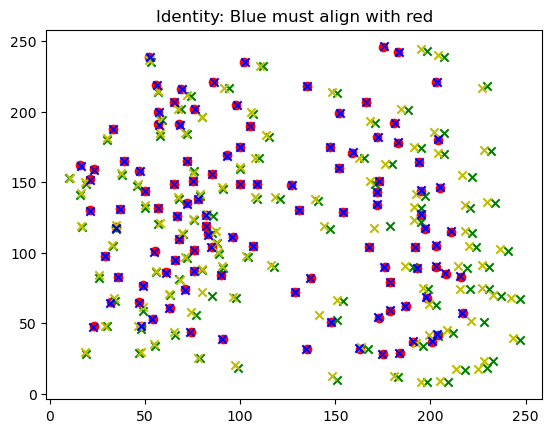

In [31]:
transformed_points = transform_points_DVF(pt1_T, identity, A)
# show the original points and the transformed points
plt.scatter(pt1_T[:, 0], pt1_T[:, 1], c='r')
plt.scatter(pt2_T[:, 0], pt2_T[:, 1], c='g', marker='x')
plt.scatter(pt3_T[:, 0], pt3_T[:, 1], c='y', marker='x')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='b', marker='x')
plt.title('Identity: Blue must align with red')
plt.show()

In [32]:
# Reshape tensor points to have dimensions [2, N]
points = pt1[0].long()

# Use torch.gather to select values from A using indices from points
result = A[:, points[:, 0], points[:, 1]]

print(result)


tensor([[0.6353, 0.1961, 0.5686, 0.2588, 0.6941, 0.6902, 0.1725, 0.5255, 0.6863,
         0.3020, 0.2039, 0.3765, 0.2588, 0.3098, 0.0902, 0.5608, 0.7569, 0.7412,
         0.2118, 0.3647, 0.2863, 0.6863, 0.3765, 0.1333, 0.2353, 0.6980, 0.3451,
         0.2627, 0.7255, 0.1020, 0.6549, 0.6745, 0.6549, 0.1843, 0.5294, 0.5255,
         0.2824, 0.9922, 0.4627, 0.2902, 0.2471, 0.1137, 0.7020, 0.6000, 0.3490,
         0.5176, 0.2588, 0.5490, 0.0549, 0.3216, 0.5490, 0.2353, 0.3373, 0.0941,
         0.4196, 0.5843, 0.2667, 0.6902, 0.1725, 0.8275, 0.5490, 0.5176, 0.3725,
         0.5020, 0.3922, 0.2235, 0.1412, 0.2824, 0.5373, 0.0941, 0.0706, 0.7020,
         0.3608, 0.6118, 0.4353, 0.0627, 0.1020, 0.7843, 0.7412, 0.2549, 0.8118,
         0.5216, 0.6314, 0.1255, 0.3529, 0.6157, 0.3412, 0.5098, 0.3882, 0.3686,
         0.0784, 0.5176, 0.5843, 0.0471, 0.4980, 0.6980, 0.6039, 0.3373, 0.5020,
         0.4627, 0.2510, 0.2000, 0.0863, 0.7412, 0.6000, 0.3137, 0.6902, 0.3529]])


In [33]:
result.shape

torch.Size([1, 108])

# 1. Homogeneous affine matrix

In [34]:
class AffineTransform(nn.Module):
    def __init__(self):
        super(AffineTransform, self).__init__()

    def forward(self, points, matrix):
        points = points.T
        # Add a row of ones to the input points for the affine transformation
        ones = torch.ones(1, points.shape[1], dtype=points.dtype, device=points.device)
        points_homogeneous = torch.cat([points, ones], dim=0)

        # Ensure that the matrix is a 2-dimensional tensor
        matrix = matrix.view(2, 3)

        # Apply the affine transformation
        # print dtype of matrix and points_homogeneous
        transformed_points = torch.mm(matrix.float(), points_homogeneous.float())

        return transformed_points[:2, :]

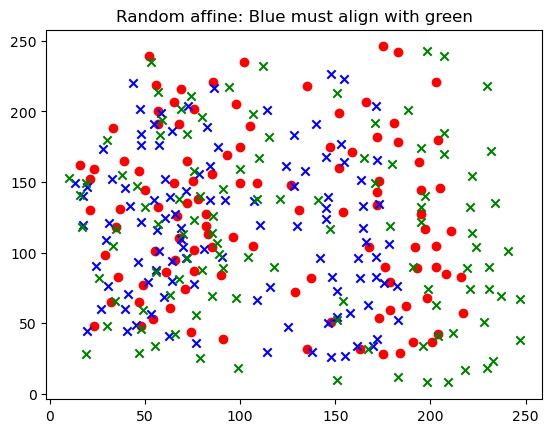

In [35]:
affine_layer = AffineTransform()
transformed_points = affine_layer(pt1[0], affine_param).T
transformed_points.shape

# show the original points and the transformed points
plt.scatter(pt1_T[:, 0], pt1_T[:, 1], c='r')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='b', marker='x')
plt.scatter(pt2_T[:, 0], pt2_T[:, 1], c='g', marker='x')
# plt.scatter(pt3_T[:, 0], pt3_T[:, 1], c='y')
plt.title('Random affine: Blue must align with green')
plt.show()

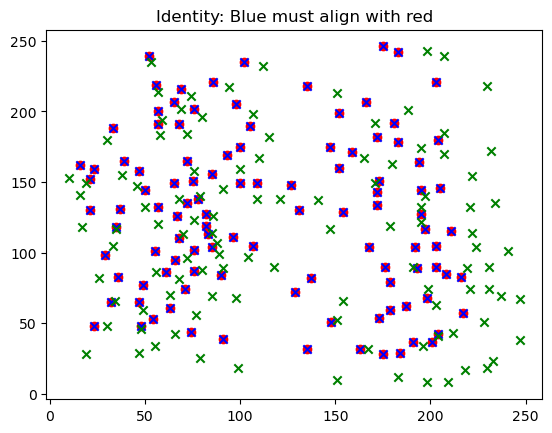

In [36]:
affine_layer = AffineTransform()
transformed_points = affine_layer(pt1[0], identity).T

# show the original points and the transformed points
plt.scatter(pt1_T[:, 0], pt1_T[:, 1], c='r')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='b', marker='x')
plt.scatter(pt2_T[:, 0], pt2_T[:, 1], c='g', marker='x')
# plt.scatter(pt3_T[:, 0], pt3_T[:, 1], c='y')
plt.title('Identity: Blue must align with red')
plt.show()

# Same as no 1 ?

In [37]:
def transform_to_displacement_field(tensor, tensor_transform, device='cpu'):
    """
    Transforms a tensor using an affine transformation matrix and returns the corresponding displacement field.

    Args:
        tensor (torch.Tensor): The input tensor to transform, with shape (batch_size, channels, height, width).
        tensor_transform (torch.Tensor): The affine transformation matrix, with shape (batch_size, 2, 3).
        device (str, optional): The device to use for the computation (default: 'cpu').

    Returns:
        torch.Tensor: The displacement field tensor, with shape (2, height, width).
    """
    # function code here
    y_size, x_size = tensor.size(2), tensor.size(3)
    deformation_field = F.affine_grid(tensor_transform, tensor.size(), align_corners=False)
    gy, gx = torch.meshgrid(torch.arange(y_size), torch.arange(x_size))
    gy = gy.type(torch.FloatTensor).to(device)
    gx = gx.type(torch.FloatTensor).to(device)
    grid_x = (gx / (x_size - 1) - 0.5) * 2
    grid_y = (gy / (y_size - 1) - 0.5) * 2
    u_x = deformation_field[0, :, :, 0] - grid_x
    u_y = deformation_field[0, :, :, 1] - grid_y
    u_x = u_x / 2 * (x_size - 1)
    u_y = u_y / 2 * (y_size - 1)
    displacement_field = torch.cat((u_x.view(1, y_size, x_size), u_y.view(1, y_size, x_size)), dim=0)
    return displacement_field

In [38]:
def transform_points_DVF(points, M, image):
    # transform points using displacement field
    # DVF.shape = (2, H, W)
    # points.shape = (2, N)
    displacement_field = torch.zeros(image.shape[-1], image.shape[-1])
    DVF = transform_to_displacement_field(
        displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)), 
        M.view(1, 2, 3))

    # Reshape tensor points to have dimensions [2, N]
    points = points.t().long()

    # Use torch.gather to select values from A using indices from points
    result = DVF[:, points[:, 0], points[:, 1]]

    # Reshape result to have dimensions [2, N]
    result = result.t()
    # subtract the result from the original points
    points = points.float()
    result = torch.subtract(points, result)
    return result

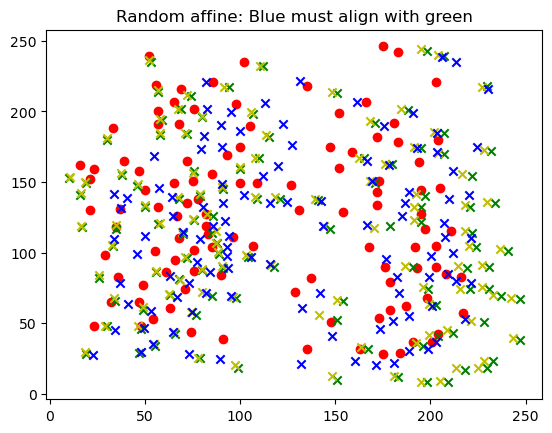

In [44]:
transformed_points = transform_points_DVF(points.T, affine_param, A)
# show the original points and the transformed points
plt.scatter(points[:, 0], points[:, 1], c='r')

plt.scatter(pt2_T[:, 0], pt2_T[:, 1], c='g', marker='x')
plt.scatter(pt3_T[:, 0], pt3_T[:, 1], c='y', marker='x')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='b', marker='x')
plt.title('Random affine: Blue must align with green')
plt.show()

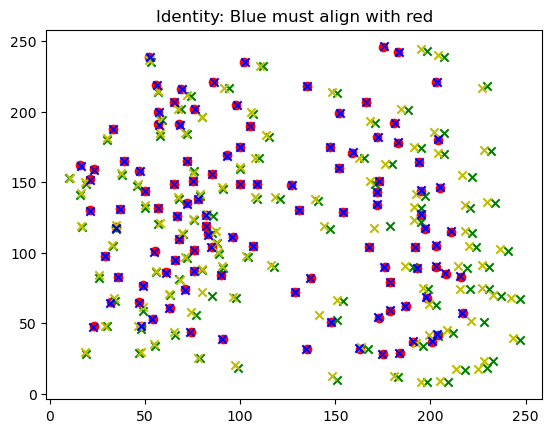

In [46]:
transformed_points = transform_points_DVF(points.T, identity, A)
# show the original points and the transformed points
plt.scatter(pt1_T[:, 0], pt1_T[:, 1], c='r')
plt.scatter(pt2_T[:, 0], pt2_T[:, 1], c='g', marker='x')
plt.scatter(pt3_T[:, 0], pt3_T[:, 1], c='y', marker='x')
plt.scatter(transformed_points[:, 0], transformed_points[:, 1], c='b', marker='x')
plt.title('Identity: Blue must align with red')
plt.show()

# Sparse matrix
- Use the points as the index of the sparse zero matrix
- Expand the matrix to the size of the image and use the points as the index of ones
- Do the element-wise multiplication between the expanded matrix and the DVFs (x and y DVF)
- Reverse the expanded matrix to the size of the points
- Implement this as a loss function

In [69]:
class sparse_point_loss:
    def __init__(self, image_size, device):
        self.image_size = image_size
        self.device = device

    def __call__(self, points, M):
        # transform points using displacement field
        # DVF.shape = (2, H, W)
        # points.shape = (2, N)
        displacement_field = torch.zeros(self.image_size, self.image_size)
        DVF = transform_to_displacement_field(
            displacement_field.view(1, 1, displacement_field.size(0), displacement_field.size(1)), 
            M.view(1, 2, 3))
        
        # create a sparse ones matrix with dimensions [2, H, W]
        # Use the points as the index of the sparse zero matrix
        # Use the points as the index of ones
        # Use torch.sparse_coo_tensor to create the sparse matrix
        point_sparse = torch.sparse_coo_tensor(points, torch.ones(points.shape[1]), size=(self.image_size, self.image_size))
        
        # convert sparse tensor to dense tensor
        point_dense = point_sparse.to_dense()

        # visualize the dense matrix
        plt.imshow(point_dense, cmap='gray')
        
        # expand the dense matrix to have dimensions [2, H, W]
        point_dense = point_dense.expand(2, self.image_size, self.image_size)
        
        # element-wise multiplication of the dense matrix with DVF
        result_x = torch.mul(point_dense, DVF[0])
        result_y = torch.mul(point_dense, DVF[1])
        print(result_x)
        print(result_y)

        # # Reshape result to have dimensions [2, N]
        # result = result.t()
        # # subtract the result from the original points
        # points = points.float()
        # result = torch.subtract(points, result)
        return result

tensor([[[0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.],
         ...,
         [0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.]],

        [[0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.],
         ...,
         [0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.],
         [0., 0., 0.,  ..., -0., -0., -0.]]])
tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]],

        [[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],


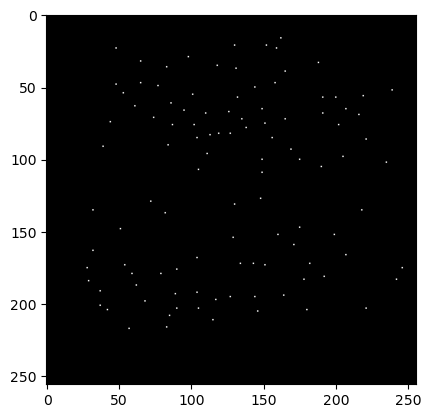

In [70]:
sparse_loss = sparse_point_loss(256, device)
transformed_points = sparse_loss(points.T, affine_param)

In [65]:
points

tensor([[ 75, 151],
        [ 90,  84],
        [195, 144],
        [ 68, 110],
        [ 50, 144],
        [ 35, 118],
        [ 49,  77],
        [217,  57],
        [203, 105],
        [ 57, 200],
        [ 56, 219],
        [195, 127],
        [ 66,  95],
        [107, 105],
        [176,  90],
        [216,  83],
        [172, 134],
        [100, 149],
        [ 36,  83],
        [ 29,  98],
        [192, 104],
        [152, 160],
        [197, 117],
        [102, 235],
        [ 61,  86],
        [ 78, 138],
        [ 76, 102],
        [ 85, 104],
        [109, 149],
        [ 32,  65],
        [203,  90],
        [ 67, 126],
        [179,  59],
        [137,  82],
        [ 47, 158],
        [ 93, 169],
        [ 55, 101],
        [ 69, 216],
        [179,  79],
        [168, 104],
        [166, 207],
        [ 74,  44],
        [193,  89],
        [159, 171],
        [184,  29],
        [ 21, 130],
        [148,  51],
        [ 33, 188],
        [ 52, 239],
        [105, 190],
